# Соревнование “Flight Delays”

Задачей этого соревнования является предсказание задержек рейсов. Предстояло проанализировать предоставленные данные, построить модели машинного обучения и улучшить их с целью достижения точности предсказаний выше 0.7 (метрика AUC-ROC).

Файл submission был размещен на платформе Kaggle. Метрика AUC-ROC составила 0,729:
https://www.kaggle.com/code/annbulkina/notebookdec703d0b6/notebook


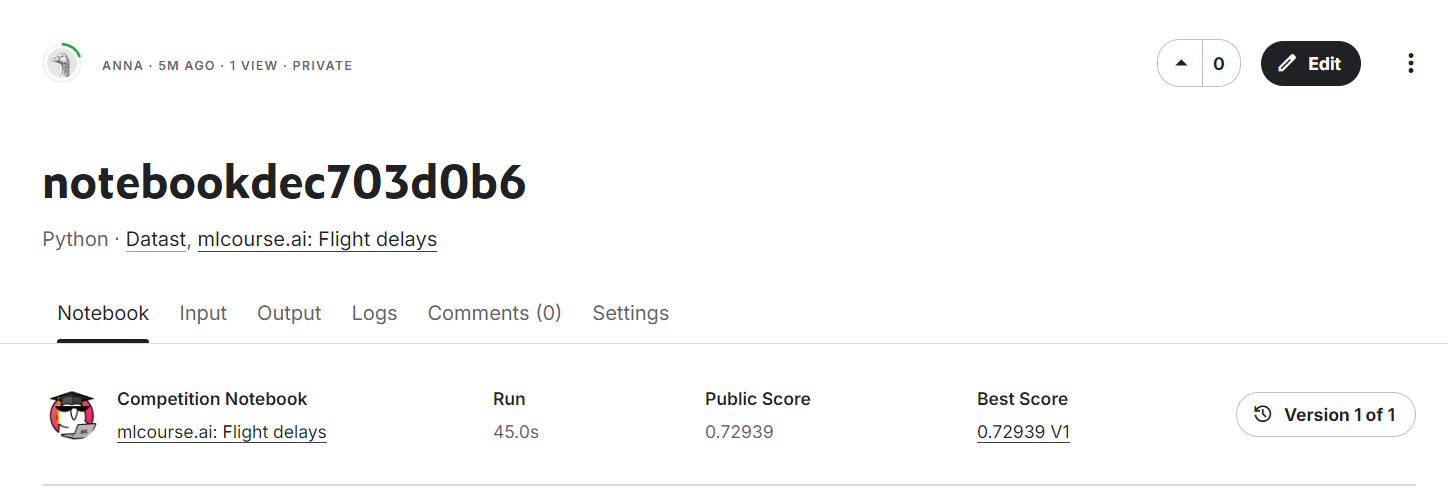

## 1. Предобработка данных

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip3 install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif, chi2, RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import catboost as cb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [ ]:
def get_url(start):
  url='https://drive.google.com/uc?id=' + start.split('/')[-2]
  return url

In [ ]:
url_test = 'https://drive.google.com/file/d/1koyD7ys_aFVkCCQo8H_oAFkT6VJ0Y7Jm/view?usp=sharing'
url_train = 'https://drive.google.com/file/d/1aT9gN6f71MLLqMsWnWyB7gVoICbqsnGe/view?usp=sharing'
url_submission = 'https://drive.google.com/file/d/1XjQqzG0LNSKcbr_6Tf_bGYzulYNYtpgn/view?usp=sharing'

In [ ]:
train = pd.read_csv(get_url(url_train))
test = pd.read_csv(get_url(url_test))
submission = pd.read_csv(get_url(url_submission))

In [ ]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


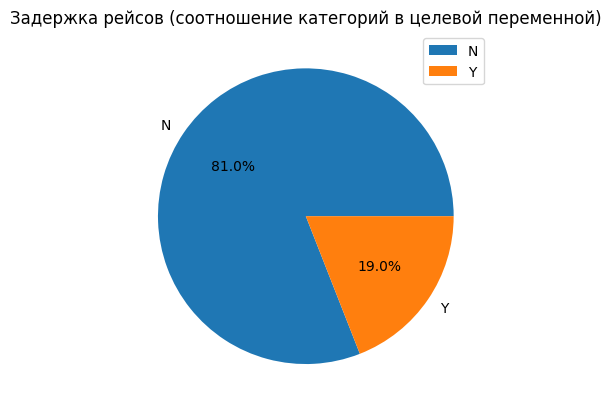

In [ ]:
train['dep_delayed_15min'].value_counts().plot.pie(autopct='%1.1f%%', legend=True,
                                                title='Задержка рейсов (соотношение категорий в целевой переменной)',
                                                ylabel='');

In [ ]:
train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [ ]:
test.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1338.936600,723.13011
std,480.554102,563.22322
min,1.000000,31.00000
25%,928.000000,321.00000
50%,1329.000000,574.00000
75%,1733.000000,948.00000
max,2400.000000,4962.00000


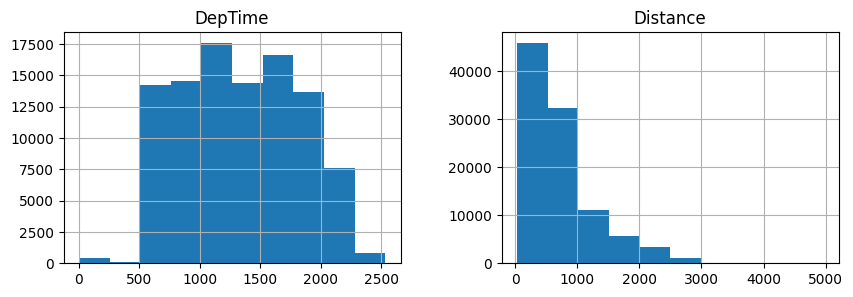

In [ ]:
train.hist(figsize=(10, 3));

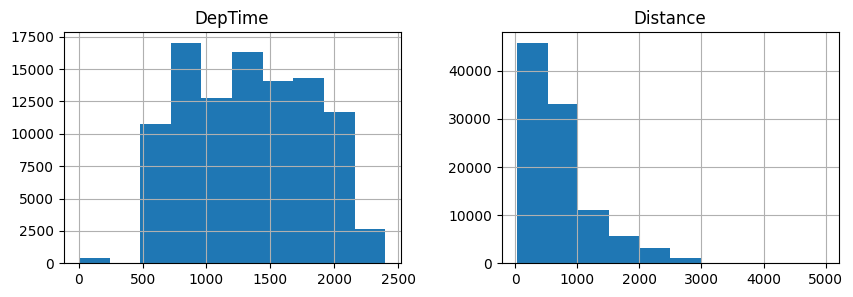

In [ ]:
test.hist(figsize=(10, 3));

In [ ]:
# columns = train[['Month', 'DayofMonth', 'DayOfWeek',
#                  'UniqueCarrier', 'Origin', 'Dest', 'dep_delayed_15min']].columns.tolist()
# print('train')
# for column in columns:
#   print(train[column].unique())

# print('test')
# columns = test[['Month', 'DayofMonth', 'DayOfWeek',
#                  'UniqueCarrier', 'Origin', 'Dest']].columns.tolist()
# for column in columns:
#   print(test[column].unique())

Явных и неявных пропусков нет

In [ ]:
#преобразование данных
train['Month'] = train['Month'].str[2:].astype('int64')
train['DayofMonth'] = train['DayofMonth'].str[2:].astype('int64')
train['DayOfWeek'] = train['DayOfWeek'].str[2:].astype('int64')

train['target'] = train['dep_delayed_15min'].apply(lambda x: 1 if x=='Y' else 0).astype('int64')
train = train.drop(['dep_delayed_15min'], axis=1)

test['Month'] = test['Month'].str[2:].astype('int64')
test['DayofMonth'] = test['DayofMonth'].str[2:].astype('int64')
test['DayOfWeek'] = test['DayOfWeek'].str[2:].astype('int64')

In [ ]:
#стандартизация
scaler = StandardScaler()
train[['DepTime', 'Distance']] = scaler.fit_transform(train[['DepTime', 'Distance']])
test[['DepTime', 'Distance']] = scaler.fit_transform(test[['DepTime', 'Distance']])

In [ ]:
#кодирование категориальных данных
train_dummies = pd.get_dummies(train, columns=['UniqueCarrier', 'Origin', 'Dest'])
test_dummies = pd.get_dummies(test, columns=['UniqueCarrier', 'Origin', 'Dest'])

In [ ]:
train_dummies.shape, test_dummies.shape

((100000, 606), (100000, 623))

По каким-то вариантам категориальных признаков есть расхождения в train и test, приведем к одному виду.

In [ ]:
train_dummies_columns = train_dummies.drop('target', axis=1).columns.to_list()
test_dummies_columns = test_dummies.columns.to_list()

In [ ]:
for i in train_dummies_columns:
  if i not in test_dummies_columns:
    test_dummies[i] = 0
#    print('В test не было', i)

In [ ]:
for i in test_dummies_columns:
  if i not in train_dummies_columns:
    train_dummies[i] = 0
#    print('В train не было', i)

In [ ]:
test_dummies = test_dummies[train_dummies.drop('target', axis = 1).columns]

In [ ]:
train_dummies.shape, test_dummies.shape

((100000, 643), (100000, 642))

## 2. Выбор модели

### 2.1. С dummy-переменными

In [ ]:
X = train_dummies.drop(['target'], axis= 1)
y = train_dummies['target']

# сплит выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# определение моделей
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': cb.CatBoostClassifier()
}

# определение гиперпараметров для поиска
param_grids = {
    'LogisticRegression': {
       'classifier__max_iter': [100, 200, 300]
    },
   'RandomForest': {
       'classifier__n_estimators': [50, 100],
       'classifier__max_depth': [10, 20]
   },
   'GradientBoosting': {
       'classifier__n_estimators': [100, 200],
       'classifier__learning_rate': [0.01, 0.1, 0.2],
       'classifier__max_depth': [3, 4, 5],
       'classifier__min_samples_split': [2, 5],
       'classifier__min_samples_leaf': [1, 2],
       'classifier__max_features': ['auto', 'sqrt'],
       'classifier__subsample': [0.8, 1.0]
   },
    'LightGBM': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
        'classifier__max_depth': [5, 10, 20]
    },
    'CatBoost': {
        'classifier__iterations': [1000],
        'classifier__learning_rate': [0.01, 0.02, 0.03],
        'classifier__depth': [5, 6],
        'classifier__l2_leaf_reg': [2, 2.5],
        'classifier__bagging_temperature': [5, 7]
    }
}

# обучение моделей

results = {}

for model_name in models:
    pipeline = Pipeline([('classifier', models[model_name])])

    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)

    results[model_name] = {
        'Best Model': best_model,
        'Best Score (CV)': best_score,
        'Best Params': best_params,
        'Test Score': test_score
    }

    print(f"Model: {model_name}")
    print(f"Best Score (CV): {-best_score}")
    print(f"Best Params: {best_params}")
    print(f"Test Score: {test_score}")
    print("\n")

Выходные данные были обрезаны до нескольких последних строк (5000).
6:	learn: 0.6274797	total: 83.6ms	remaining: 11.9s
7:	learn: 0.6196962	total: 95.7ms	remaining: 11.9s
8:	learn: 0.6124707	total: 108ms	remaining: 11.9s
9:	learn: 0.6052900	total: 120ms	remaining: 11.9s
10:	learn: 0.5992082	total: 132ms	remaining: 11.8s
11:	learn: 0.5927376	total: 144ms	remaining: 11.9s
12:	learn: 0.5864680	total: 156ms	remaining: 11.8s
13:	learn: 0.5804537	total: 168ms	remaining: 11.8s
14:	learn: 0.5748236	total: 180ms	remaining: 11.8s
15:	learn: 0.5694826	total: 192ms	remaining: 11.8s
16:	learn: 0.5642086	total: 204ms	remaining: 11.8s
17:	learn: 0.5594578	total: 221ms	remaining: 12.1s
18:	learn: 0.5551655	total: 233ms	remaining: 12s
19:	learn: 0.5506102	total: 245ms	remaining: 12s
20:	learn: 0.5464425	total: 257ms	remaining: 12s
21:	learn: 0.5422514	total: 268ms	remaining: 11.9s
22:	learn: 0.5386207	total: 280ms	remaining: 11.9s
23:	learn: 0.5349629	total: 291ms	remaining: 11.8s
24:	learn: 0.5313590	t

**Результаты поиска по сетке показали следующие результаты:**

1. **Model: LogisticRegression**

  Best Score (CV): -0.6972414558181713

  Best Params: {'classifier__max_iter': 100}

  Test Score: 0.8126

2. **Model: RandomForest**

  Best Score (CV): -0.710998100814873

  Best Params: {'classifier__max_depth': 20, 'classifier__n_estimators': 100}

  Test Score: 0.8111

3. **Model: GradientBoosting**

  Best Score (CV): -0.7232413357073234

  Best Params: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}

  Test Score: 0.81485

4. **Model: LightGBM**

   Best Score (CV): -0.7368940388928591

   Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 20, 'classifier__n_estimators': 200}

   Test Score: 0.82305

5. **Model: CatBoost**

  Best Score (CV): -0.7374141926066954

  Best Params: {'classifier__bagging_temperature': 5, 'classifier__depth': 6, 'classifier__iterations': 1000, 'classifier__l2_leaf_reg': 2, 'classifier__learning_rate': 0.03}

  Test Score: 0.82345

### 2.2. Без dummy-переменных

In [ ]:
labelencoder = LabelEncoder()
for col_name in train.columns:
    if train[col_name].dtypes=='object':
        train[col_name]=labelencoder.fit_transform(train[col_name])
        test[col_name]=labelencoder.fit_transform(test[col_name])

In [ ]:
X = train.drop(['target'], axis= 1)
y = train['target']

# сплит выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# определение моделей
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': cb.CatBoostClassifier(cat_features=['UniqueCarrier', 'Origin', 'Dest'])
}

# определение гиперпараметров для поиска
param_grids = {
    'LogisticRegression': {
       'classifier__max_iter': [100, 200, 300]
    },
   'RandomForest': {
       'classifier__n_estimators': [100, 200],
       'classifier__max_depth': [20]
   },
   'GradientBoosting': {
       'classifier__n_estimators': [100, 200],
       'classifier__learning_rate': [0.01, 0.1, 0.2],
       'classifier__max_depth': [3, 4, 5],
       'classifier__min_samples_split': [2, 5],
       'classifier__min_samples_leaf': [2, 5],
       'classifier__max_features': ['sqrt'],
       'classifier__subsample': [1.0]
   },
    'LightGBM': {
        'classifier__n_estimators': [200, 500],
        'classifier__learning_rate': [0.05],
        'classifier__max_depth': [20, 30]
    },
    'CatBoost': {
        'classifier__iterations': [1000],
        'classifier__learning_rate': [0.01, 0.02, 0.03],
        'classifier__depth': [5, 6],
        'classifier__l2_leaf_reg': [2, 2.5],
        'classifier__bagging_temperature': [5, 7]
    }
}

# обучение моделей

results = {}

for model_name in models:
    pipeline = Pipeline([('classifier', models[model_name])])

    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=3, scoring='roc_auc')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)

    results[model_name] = {
        'Best Model': best_model,
        'Best Score (CV)': best_score,
        'Best Params': best_params,
        'Test Score': test_score
    }

    print(f"Model: {model_name}")
    print(f"Best Score (CV): {-best_score}")
    print(f"Best Params: {best_params}")
    print(f"Test Score: {test_score}")
    print("\n")

Выходные данные были обрезаны до нескольких последних строк (5000).
6:	learn: 0.6281155	total: 559ms	remaining: 1m 19s
7:	learn: 0.6201266	total: 646ms	remaining: 1m 20s
8:	learn: 0.6125596	total: 737ms	remaining: 1m 21s
9:	learn: 0.6061064	total: 790ms	remaining: 1m 18s
10:	learn: 0.5992233	total: 890ms	remaining: 1m 19s
11:	learn: 0.5929088	total: 985ms	remaining: 1m 21s
12:	learn: 0.5865241	total: 1.07s	remaining: 1m 21s
13:	learn: 0.5808793	total: 1.13s	remaining: 1m 19s
14:	learn: 0.5754498	total: 1.22s	remaining: 1m 20s
15:	learn: 0.5700146	total: 1.31s	remaining: 1m 20s
16:	learn: 0.5648549	total: 1.41s	remaining: 1m 21s
17:	learn: 0.5599514	total: 1.49s	remaining: 1m 21s
18:	learn: 0.5552003	total: 1.59s	remaining: 1m 22s
19:	learn: 0.5509425	total: 1.64s	remaining: 1m 20s
20:	learn: 0.5465974	total: 1.72s	remaining: 1m 20s
21:	learn: 0.5425256	total: 1.77s	remaining: 1m 18s
22:	learn: 0.5387842	total: 1.82s	remaining: 1m 17s
23:	learn: 0.5352454	total: 1.87s	remaining: 1m 15s


**Результаты поиска по сетке показали следующие результаты:**
1. **Model: LogisticRegression**
   Best Score (CV): -0.6818489559277054
   Best Params: {'classifier__max_iter': 200}
   Test Score: 0.8111

2. **Model: RandomForest**
  Best Score (CV): -0.7274625916611245
  Best Params: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}
  Test Score: 0.8219

3. **Model: GradientBoosting**
  Best Score (CV): -0.7327405408323125
  Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
  Test Score: 0.8223

4. **Model: LightGBM**
  Best Score (CV): -0.7366015499868208
  Best Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 20, 'classifier__n_estimators': 500}
  Test Score: 0.8251

5. **Model: CatBoost**
  Best Score (CV): -0.7391518440526559
  Best Params: {'classifier__bagging_temperature': 5, 'classifier__depth': 6, 'classifier__iterations': 1000, 'classifier__l2_leaf_reg': 2.5, 'classifier__learning_rate': 0.03}
  Test Score: 0.82375

## 3. Проверка качества модели

В качестве финальной модели выберем модель LightGBM с параметрами:

{'classifier__learning_rate': 0.05, 'classifier__max_depth': 20, 'classifier__n_estimators': 200}

In [ ]:
X = train_dummies.drop(['target'], axis= 1)
y = train_dummies['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier(n_estimators=200,
                           learning_rate=0.05,
                           max_depth=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

[LightGBM] [Info] Number of positive: 15266, number of negative: 64734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 456
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190825 -> initscore=-1.444658
[LightGBM] [Info] Start training from score -1.444658


In [ ]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC:', roc_auc)

Accuracy: 0.82305
Precision: 0.7137745974955277
Recall: 0.10561143462149285
F1 Score: 0.18399815540696335
ROC AUC: 0.7466239258112639


In [ ]:
# K-Fold кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=skf)

[LightGBM] [Info] Number of positive: 15236, number of negative: 64764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1451
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 449
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190450 -> initscore=-1.447089
[LightGBM] [Info] Start training from score -1.447089
[LightGBM] [Info] Number of positive: 15235, number of negative: 64765
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 452
[LightGBM] [Info

In [ ]:
print(f'Stratified cross-validation scores: {scores}')
print(f'Mean stratified cross-validation score: {scores.mean()}')

Stratified cross-validation scores: [0.82135 0.8202  0.8219  0.8216  0.82265]
Mean stratified cross-validation score: 0.82154


## 4. Предсказания

In [ ]:
y_pred = model.predict(test_dummies)
y_proba = model.predict_proba(test_dummies)[:, 1]

In [ ]:
submission['dep_delayed_15min'] = y_proba

In [ ]:
submission.to_csv('submission.csv', index=False)

## 4. Вывод

Среди всех моделей наилучший результат показали модели CatBoost и LightGBM.

Для итоговых предсказаний я выбрала модель LightGBM, поскольку она требовала меньше ресурсов для обучения. Среди двух наборов фичей я остановилась на дамми-переменных, поскольку в этом случае предсказания были наиболее стабильными.

Гиперпараметры были подобраны по сетке: n_estimators=200, learning_rate=0.05, max_depth=20.

На тестовой выборке модель показала результат roc_auc = 0,729.